## 데이터 준비
* 목표는 모델을 훈련시키고, 정위치 이미지와 오위치 이미지의 softmax 값과 entropy를 추출해 확인해 보는 것

In [1]:
import os
import numpy as np
from statistics import mean

import torch
import torchvision

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy import stats

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

PROJECT_PATH = os.getenv('HOME') + '/aiffel/socar_open_set'
MODEL_PATH = os.path.join(PROJECT_PATH, 'weights')
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
REJECT_PATH = os.path.join(DATA_PATH, 'reject')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # 여기서 'cuda'가 출력되어야 GPU와 연결이 됩니다

cuda


/aiffel/aiffel/socar_open_set/data/train/atower_b5/b5.mp4_frame830.jpg
size: (1920, 1080, ('R', 'G', 'B'))


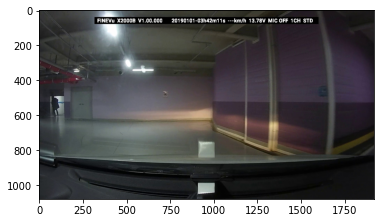

/aiffel/aiffel/socar_open_set/data/train/balsan_b5/20190104-08h19m55s_F_N.mp4_frame773.jpg
size: (1920, 1080, ('R', 'G', 'B'))


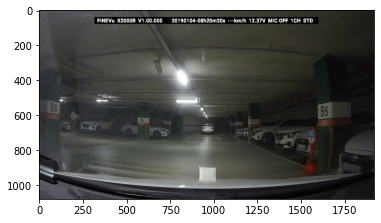

/aiffel/aiffel/socar_open_set/data/train/dcube_b6/20190104-09h17m17s_F_N.mp4_frame453.jpg
size: (1920, 1080, ('R', 'G', 'B'))


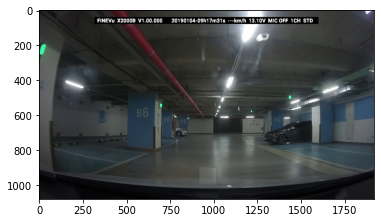

/aiffel/aiffel/socar_open_set/data/train/balsan_b6/20190104-08h17m55s_F_N.mp4_frame1469.jpg
size: (1920, 1080, ('R', 'G', 'B'))


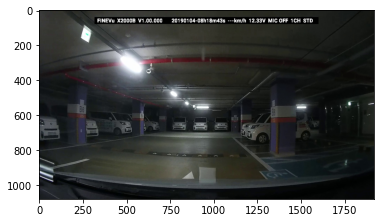

In [2]:
# 쏘카의 블랙박스에서 촬영된 정위치 이미지를 확인
for dirpath, dirnames, filenames in os.walk(TRAIN_PATH):
    for i, filename in enumerate(filenames):
        print(os.path.join(dirpath, filename)) # 파일이름을 출력합니다
        image = Image.open(os.path.join(dirpath, filename), 'r')
        print(f'size: ({image.width}, {image.height}, {image.getbands()})') # 이미지 정보를 출력합니다
        plt.imshow(image)
        plt.show()
        break # 폴더마다 1장만 출력합니다

/aiffel/aiffel/socar_open_set/data/reject/images/01허2177_20210523_160550_DS_1.jpg
size: (1280, 720, ('R', 'G', 'B'))


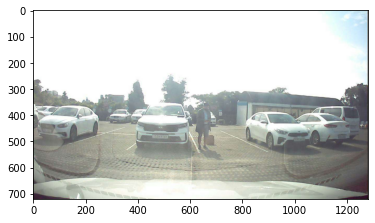

/aiffel/aiffel/socar_open_set/data/reject/images/40호6003_20210524_003559_DS_1.jpg
size: (1280, 720, ('R', 'G', 'B'))


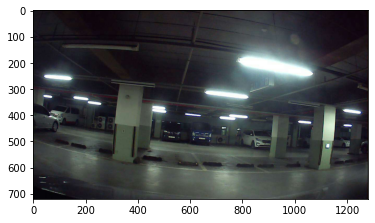

/aiffel/aiffel/socar_open_set/data/reject/images/124하3906_20210524_115630_DS_1.jpg
size: (1280, 720, ('R', 'G', 'B'))


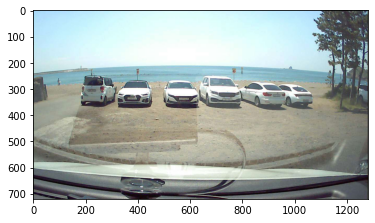

/aiffel/aiffel/socar_open_set/data/reject/images/29호5759_20210524_132705_DS_1.jpg
size: (1280, 720, ('R', 'G', 'B'))


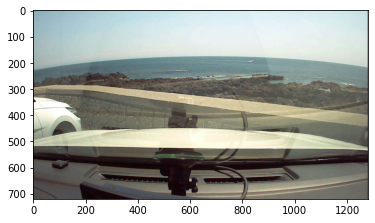

/aiffel/aiffel/socar_open_set/data/reject/images/19하4188_20210523_224153_DS_1.jpg
size: (1280, 720, ('R', 'G', 'B'))


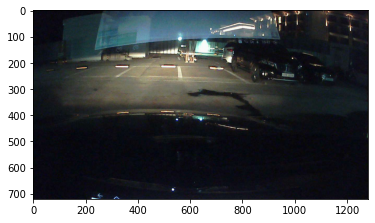

In [3]:
# 오위치 이미지 5장을 출력하는 코드
for dirpath, dirnames, filenames in os.walk(REJECT_PATH):
    for i, filename in enumerate(filenames):
        print(os.path.join(dirpath, filename)) # 파일이름을 출력합니다
        image = Image.open(os.path.join(dirpath, filename), 'r')
        print(f'size: ({image.width}, {image.height}, {image.getbands()})') # 이미지 정보를 출력합니다
        plt.imshow(image)
        plt.show()
        if i == 4:
            break

### 데이터 전처리 파이프라인
* 모델에 입력할 이미지 크기는 224x224
* Resize를 한 후 CenterCrop을 적용
* 그 외에도 다른 augmentation기법을 추가해 create_dataloader를 만들어 데이터셋 파이프라인을 설치

In [4]:
def create_dataloader(path, batch_size, istrain):
    nearest_mode = torchvision.transforms.InterpolationMode.NEAREST
    normalize = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
    )
    train_transformer = torchvision.transforms.Compose([
        torchvision.transforms.Resize((320,320), interpolation=nearest_mode),
        torchvision.transforms.CenterCrop((224,224)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ColorJitter(),
        torchvision.transforms.ToTensor(),
        normalize
    ])

    test_transformer = torchvision.transforms.Compose([
        torchvision.transforms.Resize((320,320), interpolation=nearest_mode),
        torchvision.transforms.CenterCrop((224,224)),
        torchvision.transforms.ToTensor(),
        normalize
    ])
    
    if istrain:
        data = torchvision.datasets.ImageFolder(path, transform=train_transformer)
        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
    else:
        data = torchvision.datasets.ImageFolder(path, transform=test_transformer)
        dataloader = torch.utils.data.DataLoader(data, shuffle=False)

    return dataloader, data

In [5]:
# 위에서 만든 함수를 이용해 train데이터셋 준비
BATCH_SIZE = 64

train_loader, _train_data = create_dataloader(TRAIN_PATH, BATCH_SIZE, True)
target_class_num = len(os.listdir(os.path.join(TRAIN_PATH)))

print('target_class_num: ', target_class_num)
print('train: ', _train_data.class_to_idx)

target_class_num:  4
train:  {'atower_b5': 0, 'balsan_b5': 1, 'balsan_b6': 2, 'dcube_b6': 3}


In [6]:
# test 데이터셋을 준비(shuffle하지 않음)
test_loader, _test_data = create_dataloader(TEST_PATH, BATCH_SIZE, False) 

print('test: ', _test_data.class_to_idx)

test:  {'atower_b5': 0, 'balsan_b5': 1, 'balsan_b6': 2, 'dcube_b6': 3}


In [7]:
# train 데이터 이미지 갯수 확인
for dirpath, dirnames, filenames in os.walk(TRAIN_PATH):
    print(f'{dirpath}:{len(filenames)}')

/aiffel/aiffel/socar_open_set/data/train:0
/aiffel/aiffel/socar_open_set/data/train/atower_b5:1250
/aiffel/aiffel/socar_open_set/data/train/balsan_b5:1250
/aiffel/aiffel/socar_open_set/data/train/dcube_b6:1250
/aiffel/aiffel/socar_open_set/data/train/balsan_b6:1250


In [8]:
# test 데이터 이미지 갯수 확인
for dirpath, dirnames, filenames in os.walk(TEST_PATH):
    print(f'{dirpath}:{len(filenames)}')

/aiffel/aiffel/socar_open_set/data/test:0
/aiffel/aiffel/socar_open_set/data/test/atower_b5:250
/aiffel/aiffel/socar_open_set/data/test/balsan_b5:250
/aiffel/aiffel/socar_open_set/data/test/dcube_b6:250
/aiffel/aiffel/socar_open_set/data/test/balsan_b6:250


## 모델 훈련
* 모델이 학습하는 구조     
for epoch in range(epochs):     
  모델_훈련(train_data)     
  모델_정확도_계산(test_data)    
  if 모델 정확도가 커졌다면:      
    좋은 모델이므로 중간 저장

### Metric 함수
* 모델의 정확도를 측정할 때 사용할 metric 함수
* metric에는 accuray_score, f1_score, precision_score, recall_score를 사용

In [9]:
def calculate_metrics(trues, preds):
    accuracy = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    precision = precision_score(trues, preds, average='macro')
    recall = recall_score(trues, preds, average='macro')
    return accuracy, f1, precision, recall

### Train 함수
* 1 epoch 당 1회 수행되는 train 함수
* optimizer로 Adam을 사용
* loss 함수로 CrossEntropyLoss를 사용하고 loss.backward()라는 함수를 사용
* loss.backward()에서는 gradient를 계산만 함
* optimizer.step()에서는 주어진 gradient를 가지고 파라미터 업데이트를 함
* optimizer.zero_grad()에서는 이전에 적용된 gradient를 초기화해서 gradient들이 중복으로 계산되는 것을 막아줌

In [10]:
def train(dataloader, net, learning_rate, weight_decay_level, device):
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = learning_rate, 
        weight_decay = weight_decay_level
    )

    net.train()

    train_losses = list()
    train_preds = list()
    train_trues = list()

    for idx, (img, label) in enumerate(dataloader):

        img = img.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        out = net(img)

        _, pred = torch.max(out, 1)
        loss = criterion(out, label)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_trues.extend(label.view(-1).cpu().numpy().tolist())
        train_preds.extend(pred.view(-1).cpu().detach().numpy().tolist())

    acc, f1, prec, rec = calculate_metrics(train_trues, train_preds)

    print('\n''====== Training Metrics ======')
    print('Loss: ', mean(train_losses))
    print('Acc: ', acc)
    print('F1: ', f1)
    print('Precision: ', prec)
    print('Recall: ', rec)
    print(confusion_matrix(train_trues, train_preds))

    return net, acc, f1, prec, rec

### Test 함수
* net.eval()함수는 학습을 진행할 때와 아닐 때의 모델의 상태를 변환시켜주는 함수
* PyTorch에서 모델은 train()을 통해 training이 가능한 상태가 되었다가, eval()을 통해 evaluating이 가능한 상태가 됨

In [11]:
def test(dataloader, net, device):

    criterion = torch.nn.CrossEntropyLoss()
    
    net.eval()
    test_losses = list()
    test_trues = list()
    test_preds = list()
    
    with torch.no_grad():
        for idx, (img, label) in enumerate(dataloader):

            img = img.to(device)
            label = label.to(device)

            out = net(img)

            _, pred = torch.max(out, 1)
            loss = criterion(out, label)

            test_losses.append(loss.item())
            test_trues.extend(label.view(-1).cpu().numpy().tolist())
            test_preds.extend(pred.view(-1).cpu().detach().numpy().tolist())

    acc, f1, prec, rec = calculate_metrics(test_trues, test_preds)

    print('====== Test Metrics ======')
    print('Test Loss: ', mean(test_losses))
    print('Test Acc: ', acc)
    print('Test F1: ', f1)
    print('Test Precision: ', prec)
    print('Test Recall: ', rec)
    print(confusion_matrix(test_trues, test_preds))

    return net, acc, f1, prec, rec

### 학습을 위한 함수
* 훈련-평가-저장이 반복되는 구조일뿐 나머지는 폴더를 만들고 가장 좋은 accuracy를 저장하는 등의 부차적인 코드

In [12]:
def train_classifier(net, train_loader, test_loader, n_epochs, learning_rate, weight_decay, device):
    best_test_acc = 0
    
    model_save_path = None
    model_save_base = 'weights'
    if not os.path.exists(model_save_base):
        os.makedirs(model_save_base)
    
    print('>> Start Training Model!')
    for epoch in range(n_epochs):
        
        print('> epoch: ', epoch)

        net, _, _, _, _ = train(train_loader, net, learning_rate, weight_decay, device)
        net, test_acc, _, _, _  = test(test_loader, net, device)

        if test_acc > best_test_acc:

            best_test_acc = test_acc
            test_acc_str = '%.5f' % test_acc

            print('[Notification] Best Model Updated!')
            model_save_path = os.path.join(model_save_base, 'classifier_acc_' + str(test_acc_str) + '.pth') 
            torch.save(net.state_dict(), model_save_path)
                
    return model_save_path

### 모델 학습
* 모델은 resnet50 사용(pretrain된 모델)

In [13]:
net = torchvision.models.resnet50(pretrained=True)
net.fc = torch.nn.Linear(
    net.fc.in_features,
    target_class_num
)

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

* 학습을 시작
* 학습이 오래 걸리기 때문에 1epoch만 수행하고 준비된 모델을 이용

In [14]:
EPOCHS = 1
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0.0005

saved_weight_path = train_classifier(net, train_loader, test_loader, EPOCHS, LEARNING_RATE, WEIGHT_DECAY, device)

>> Start Training Model!
> epoch:  0

====== Training Metrics ======
Loss:  0.7043492512989648
Acc:  0.6816
F1:  0.6840699721499
Precision:  0.6871499835686485
Recall:  0.6816
[[1084   96   33   37]
 [  50  678  347  175]
 [  21  386  717  126]
 [  17  146  158  929]]
====== Test Metrics ======
Test Loss:  1.4423858130385276
Test Acc:  0.531
Test F1:  0.48250317934381165
Test Precision:  0.7028136029954505
Test Recall:  0.531
[[168  24   0  58]
 [  0  96   0 154]
 [  0 157  17  76]
 [  0   0   0 250]]
[Notification] Best Model Updated!


## Confidence
* 미리 준비한 모델을 불러옵니다. 20 epochs를 학습시킨 모델

In [16]:
saved_weight_path = os.path.join(MODEL_PATH, 'classifier_acc_0.96008.pth')

net = torchvision.models.resnet50(pretrained=True)
net.fc = torch.nn.Linear(
    net.fc.in_features,
    target_class_num
)

net.load_state_dict(torch.load(saved_weight_path, map_location=device))
net.eval()
net.to(device)    

print('load')

load


### Confidence 추출
* softmax 값 중에 가장 높은 softmax값을 추출
* entropy는 아래 entropy식을 참고
* entropy=−∑(P(A)log 
2
​
 P(A))

In [17]:
def get_confidence(net, infer_loader, device):    
    container = list()
    
    with torch.no_grad():
        for idx, (img, label) in enumerate(infer_loader):
            img = img.to(device)
            label = label.to(device)
            out = net(img) 
            out_softmax = torch.softmax(out, 1)

            msp = float(out_softmax.detach().cpu().numpy().max()) # 최대 softmax 값

            pA = out_softmax.detach().cpu().numpy() / out_softmax.detach().cpu().numpy().sum()
            entropy = -np.sum( pA * np.log2(pA))

            fname, _ = infer_loader.dataset.samples[idx]
            label = int(label.detach().cpu().numpy())

            tmp_container = {
                'fname':fname,
                'label':label,
                'msp':msp,
                'entropy':entropy
            }
            container.append(tmp_container)
        
    return container

* 정위치 데이터의 confidence를 구하기
* 확인할 정위치 데이터로는 test 이미지를 사용

In [18]:
test_loader, _test_data = create_dataloader(TEST_PATH, 1, False)
print('Test: ', _test_data.class_to_idx)

test_result = get_confidence(net, test_loader, device)
print(test_result[0])

Test:  {'atower_b5': 0, 'balsan_b5': 1, 'balsan_b6': 2, 'dcube_b6': 3}
{'fname': '/aiffel/aiffel/socar_open_set/data/test/atower_b5/b5.mp4_frame1002.jpg', 'label': 0, 'msp': 1.0, 'entropy': 1.8695472e-09}


In [19]:
# 오위치 데이터의 confidence
reject_loader, _reject_data = create_dataloader(REJECT_PATH, 1, False)
print('Reject: ', _reject_data.class_to_idx)

reject_result = get_confidence(net, reject_loader, device)
print(reject_result[0])

Reject:  {'images': 0}
{'fname': '/aiffel/aiffel/socar_open_set/data/reject/images/01하3062_20210524_133530_DS_1.jpg', 'label': 0, 'msp': 0.8303816318511963, 'entropy': 0.90969384}


### 시각화

In [20]:
# 최대 softmax와 entropy를 따로 떼어내기
def parse_result(results):
    msp, entropy = list(), list()
    for result in results:
        msp.append(result['msp'])
        entropy.append(result['entropy'])
    return msp, entropy

test_msp, test_entropy = parse_result(test_result)
reject_msp, reject_entropy = parse_result(reject_result)

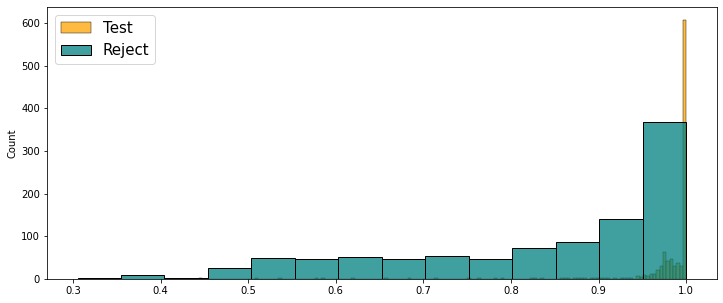

In [21]:
# 최대 Softmax 분포를 시각화 
plt.figure(figsize=(12,5))
sns.histplot(test_msp, label='Test', color='orange')
sns.histplot(reject_msp, label='Reject', color='teal')
plt.legend(fontsize=15)
plt.show()

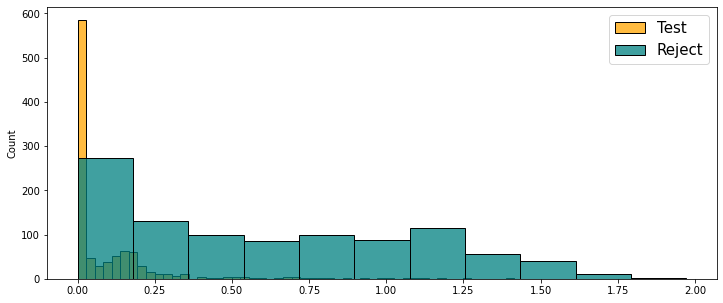

In [22]:
# Entropy 분포를 시각화
plt.figure(figsize=(12,5))
sns.histplot(test_entropy, label='Test', color='orange')
sns.histplot(reject_entropy, label='Reject', color='teal')
plt.legend(fontsize=15)
plt.show()

↑
* 오위치의 모든 데이터는 분류하지 않아야 하는 값
* 그러므로 최대 softmax가 1에 가깝지 않아야 함 entropy가 높아야 함
* 하지만 결과를 보면 최대 softmax는 1을 중심으로 퍼져있고, entropy도 0을 중심으로 퍼져있는 모양
* 만약 오위치 이미지를 완벽하게 분류하지 못하는 이상적인 상황이라면 Softmax 분포는 0.25에 집중되어 있고, entropy분포는 2에 집중되어 함
* Softmax의 합은 1입니다. 클래스가 4개이니 최대 softmax값이 0.25보다 작을 수 없음.
* 완벽하게 분류가 안되는 이상적인 상황에서는 모든 softmax 값이 0.25가 되고, 최대 softmax값도 0.25가 됨
* 클래스가 4개일 때 Entropy의 최대값은 2
* 모든 클래스의 확률이 0.25로 같을 때 entropy가 최대가 됨
* 단순하게 Test와 Reject가 반대양상으로 형성되어야 함
* 오위치 데이터가 테스트데이터와 같은 클래스로 분류되면 안되기 때문